<a href="https://colab.research.google.com/github/TEhyeok/AIFFEL_Exploration/blob/main/CIFAR_10(Optional).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8-1.프로젝트: CIFAR-10 이미지 생성하기



In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.14.0
imageio 2.31.6


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170498071/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)

In [5]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
# BUFFER_SIZE = 50000

BUFFER_SIZE = 10000 # STEP 8. (optional) GAN 훈련 과정 개선하기
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 변이형 오토인코더(VAE)
GAN 모델 중 하나인 VAE를 사용하여 잠재 표현을 학습하는 이미지 생성 모델을 만들고자 한다.

특징으로
1. 잠재 공간 표현:

- VAE는 인코더와 디코더 두 주요 구성 요소로 이루어져 있습니다.
- 인코더는 입력 데이터를 몇 개의 잠재 변수를 통해 잠재 공간으로 압축합니다.
- 디코더는 이 잠재 공간에서 데이터를 재구성하여, 입력과 유사한 데이터를 생성하는 법을 학습합니다.

2. 확률적 접근 방식:

- VAE는 잠재 공간에서 입력 데이터를 표현할 때 확률적 접근 방식을 채택합니다.
- 입력을 단일 지점으로 인코딩하는 대신, 잠재 공간에서 분포로 인코딩하는데, 이는 보통 평균과 분산으로 특징지어집니다.
- 이 확률적 특성은 모델이 데이터의 기저 분포를 포착하고 다양한 출력을 생성하는 데 도움이 됩니다.

3. 재구성 손실과 KL 발산:

- VAE의 학습 목표는 재구성 손실과 KL 발산 두 가지 주요 요소를 포함합니다.
- 재구성 손실은 디코딩된 샘플이 원본 입력에 가능한 한 가깝도록 보장합니다.
- KL 발산은 정규화 역할을 하며, 잠재 공간의 분포가 목표 분포(보통 정규 분포)에 가까워지도록 장려합니다. 이는 새로운 샘플의 부드러운 보간 및 생성에 도움이 됩니다.

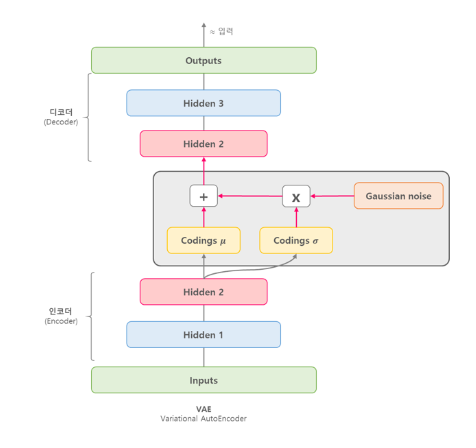

참고:
1. https://velog.io/@hong_journey/VAEVariational-AutoEncoder-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0
2. https://paperswithcode.com/method/vae
3. https://github.com/AntixK/PyTorch-VAE/blob/8700d245a9735640dda458db4cf40708caf2e77f/models/vanilla_vae.py#L8
4. https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/cvae.ipynb?hl=ko

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

# 인코더 구조
latent_dim = 64  # 잠재 공간의 차원

encoder_inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

encoder = Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 16, 16, 32)           896       ['input_8[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_8[0][0]']            
                                                                                                  
 flatten_4 (Flatten)         (None, 4096)                 0         ['conv2d_9[0][0]']            
                                                                                            

In [9]:
class Sampling(tf.keras.layers.Layer):
    """샘플링 레이어"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# 샘플링 레이어를 인코더에 연결
z = Sampling()([z_mean, z_log_var])


In [10]:
# 디코더 구조
latent_inputs = Input(shape=(latent_dim,))
x = Dense(8 * 8 * 64, activation='relu')(latent_inputs)
x = Reshape((8, 8, 64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              266240    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 3)         867 

In [11]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = Sampling()([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 32 * 32 * 3
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())


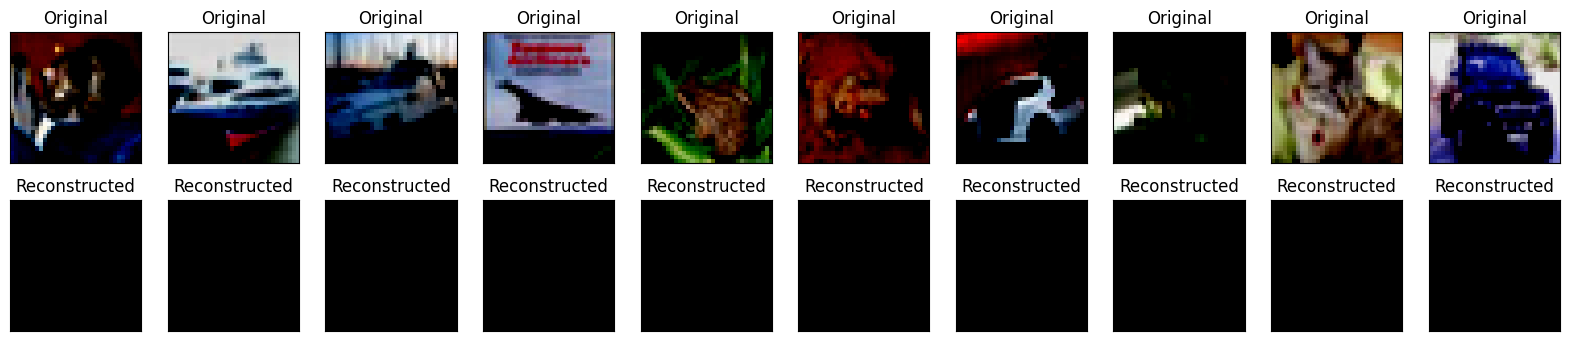

In [13]:
import matplotlib.pyplot as plt

def plot_images(original, reconstructed):
    n = 10  # 출력할 이미지의 수
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # 원본 이미지
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # 재구성된 이미지
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# 테스트 데이터셋에서 이미지 샘플 추출
test_x = (test_x - 127.5) / 127.5  # 테스트 데이터 전처리
test_sample = test_x[0:10]

# 모델을 사용하여 이미지 재구성
z_mean, z_log_var = vae.encoder(test_sample)
z = Sampling()([z_mean, z_log_var])
reconstructed = vae.decoder(z)

plot_images(test_sample, reconstructed.numpy())


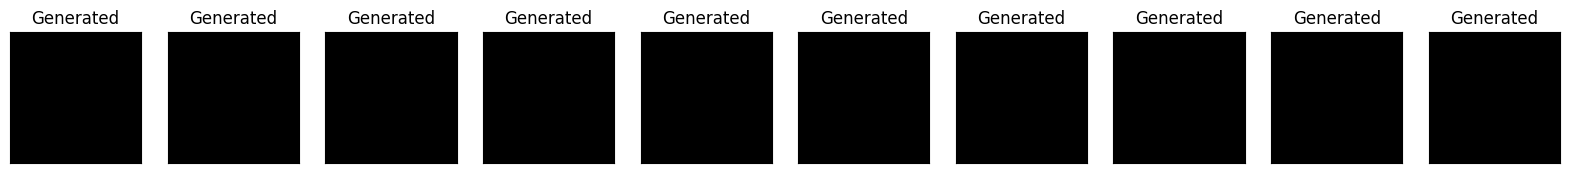

In [14]:
def generate_images(model, n_images):
    random_latent_vectors = tf.random.normal(shape=(n_images, latent_dim))
    generated_images = model.decoder(random_latent_vectors)
    generated_images = generated_images * 255
    generated_images = generated_images.numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        plt.imshow(generated_images[i])
        plt.title("Generated")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

generate_images(vae, 10)


### 여기서 제대로 재구성이 안되어서 모듈화를 하지않고 직관적으로 이해할수 있게 다시 작성 후 생성 해본다.

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# 1. 모델 구조 정의
## 인코더 정의
latent_dim = 64  # 잠재 공간의 차원

encoder_inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# 잠재 공간 샘플링 함수
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

## 디코더 정의
latent_inputs = Input(shape=(latent_dim,))
x = Dense(8 * 8 * 64, activation='relu')(latent_inputs)
x = Reshape((8, 8, 64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# 2. 손실 함수 및 최적화 알고리즘 정의
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 32 * 32 * 3
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# 3. 학습 과정 정의
(train_x, _), (test_x, _) = tf.keras.datasets.cifar10.load_data()
train_x = train_x.astype('float32') / 255
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(10000).batch(64)


In [17]:

%%time
# 모델 학습
vae.fit(train_dataset, epochs=50)

Epoch 1/50
782/782 [==============================] - 12s 10ms/step - loss: 1916.4734 - reconstruction_loss: 1914.2638 - kl_loss: 2.2097
Epoch 2/50
782/782 [==============================] - 9s 12ms/step - loss: 1870.7224 - reconstruction_loss: 1868.3201 - kl_loss: 2.4023
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 1869.1578 - reconstruction_loss: 1866.8639 - kl_loss: 2.2939
Epoch 4/50
782/782 [==============================] - 8s 10ms/step - loss: 1868.0311 - reconstruction_loss: 1865.8006 - kl_loss: 2.2305
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 1867.3679 - reconstruction_loss: 1865.1798 - kl_loss: 2.1881
Epoch 6/50
782/782 [==============================] - 7s 8ms/step - loss: 1866.7924 - reconstruction_loss: 1864.6450 - kl_loss: 2.1474
Epoch 7/50
782/782 [==============================] - 7s 9ms/step - loss: 1866.0669 - reconstruction_loss: 1863.9504 - kl_loss: 2.1166
Epoch 8/50
782/782 [==============================]

### 생성 능력을 평가하기 위해 잠재공간을 시각화 해본다.

1/1 [==============================] - 0s 32ms/step


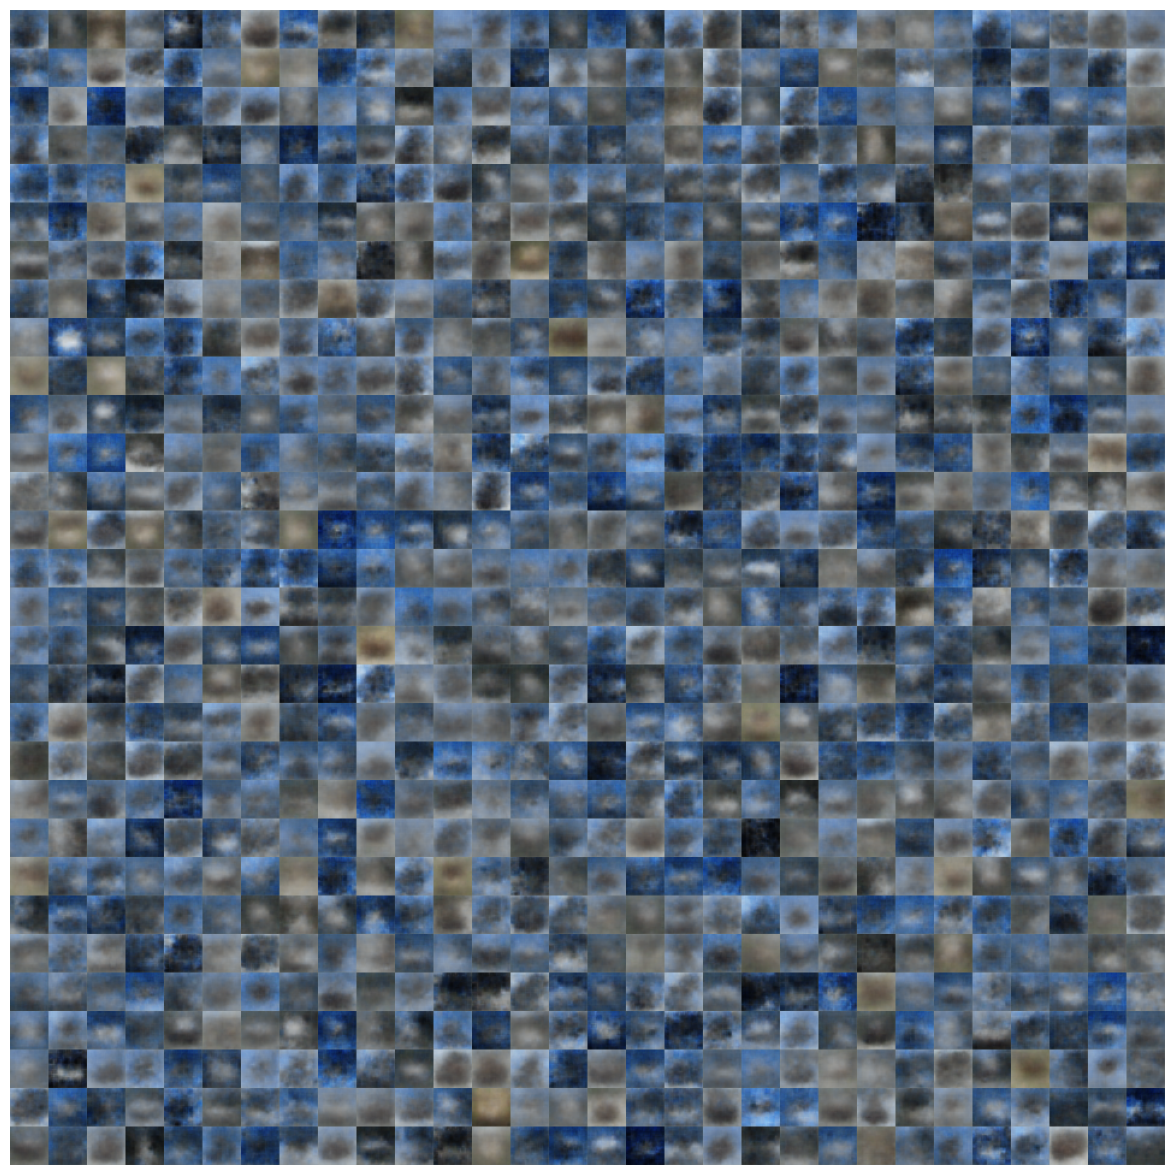

In [19]:
def plot_latent_space(vae, n=30, figsize=15):
    # n x n 그리드의 잠재 공간을 시각화
    digit_size = 32
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # 잠재 공간의 차원에 맞게 z_sample 크기 조정
            z_sample = np.random.normal(size=(1, latent_dim))
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('off')
    plt.show()

plot_latent_space(vae)
